In [6]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F

from matplotlib import pyplot as plt

use_cuda = torch.cuda.is_available()

# Define a Language Class

Parameters:
1. word2index dict
2. index2word dict
3. word2count dict - to filter-out infrequent words
4. n_count variable - for counting number of unique words in the language

Input:

1. Name of the Language -> French/English etc

Methods:

1. addSentence using addWord
2. addWord

In [7]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self,name):
        self.name = name
        self.word2index = {}
        self.index2word = {}
        self.word2count = {}
        self.n_words = 2 #Including SOS and EOS token for each language
    
    def addSentence(self,sentence):
        for word in sentence.split(' '):
            self.addWord(word)
    
    def addWord(self,word):
        if word not in self.word2index:
            self.word2count[word] = 1
            self.word2index[word] = self.n_words
            self.index2word[self.n_words] = word
            self.n_words += 1
        else :
            self.word2count[word] += 1

# Utilities for String Preprocessing

This module is already completed. This is basic string processing in python using regex and inbuilt utility functions

1. Convert string to lowerCase
2. remove leading or trailing spaces - use strip()
3. Convert all UniCode to ASCII Characters

In [8]:
# Turn a Unicode string to plain ASCII, thanks to
# http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters

def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

# Load data

Note: The data is present in eng-fra.txt file. You need to load the data using the following steps

1. Load data from file, removing spaces and splitting by new-line
2. Each line has 2 parts:
    1. The french text
    2. Tab separation '\t'
    3. The English translation
    
3. Use normalize each of the strings and create pairs of sentences.
4. define a language model
5. Return input_lang,output_lang and the pairs

In [9]:
def readLangs(lang1,lang2):
    f = open('data/LSTM/eng-fra.txt', encoding='utf-8').read().strip().split("\n")
    
    pairs = [[normalizeString(p) for p in line.split('\t')] for line in f]
    
    pairs = [list(reversed(p)) for p in pairs]
    input_lang = Lang(lang2)
    output_lang = Lang(lang1)
    
    return input_lang,output_lang,pairs

MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def filterPair(p): # boolean function. True -> keep the pair, False ->discard
    return len(p[0].split(' ')) < MAX_LENGTH and len(p[1].split(' ')) < MAX_LENGTH and p[1].startswith(eng_prefixes)

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

def prepareData(lang1,lang2):
    input_lang,output_lang,pairs = readLangs(lang1,lang2)
    pairs = filterPairs(pairs)
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    
    return input_lang,output_lang,pairs

input_lang,output_lang,pairs = prepareData('eng','fra')
print(random.choice(pairs))

Trimmed to 10853 sentence pairs
Counted words:
fra 4489
eng 2925
['vous etes plus grande que moi .', 'you are taller than me .']


# Encoder

<img src ="images/lstm2.png">

We are going to simulate the network shown above. It consists of 2 stages. One is the encoding phase and other is the decoding phase..

The Encode Module is going to follow the network structure given below. The purpose of encoder is 2 folds:

1. Outputs some value for every word in the input sequence
2. For every input word - output a vector and a hidden state.

This hidden state is used as "input" for the word of the input sequence.

<img src = "images/lstm1.png" >

Here, we are using a differen type of RNNCell - called the GRU (Gated Recurrent Unit). It is a very popular variant of LSTM Cell.

Please fill in the code below to build the encoder network. You need to fill in the RHS of each line

In [10]:
class EncoderRNN(nn.Module):
    def __init__(self,input_size,hidden_size,n_layers=1):
        super(EncoderRNN,self).__init__()
        
        # define hidden size
        self.hidden_size = hidden_size
        # define n_layers
        self.n_layers = n_layers
        # define an embedding from input_size to hidden_size
        self.embedding = nn.Embedding(input_size,hidden_size)
        # gru from hidden to hidden (hidden of embedding to output-hidden)
        self.gru = nn.GRU(hidden_size,hidden_size)
        
    def forward(self,input,hidden):
        # map embedding and reshape it to (1,1,-1) shape (seq_len,batch_Size and input_size)
        embedded = self.embedding(input).view(1,1,-1) #seq_len,batch_size = 1
        # save embedded in variable output
        output = embedded
        # for each gru layer - by default it is 1
        for i in range(self.n_layers):
            # output,hidden hold the return values from gru cell
            output,hidden = self.gru(output,hidden)
        
        # return output and hidden after each forward pass
        return output,hidden
    
    def initHidden(self):
        # return hidden layer values - zeros of size (1,1,hidden_size)
        result = Variable(torch.zeros(1,1,self.hidden_size))
        return result

# Decoder

<img src="images/lstm2.png">

Decoder is another RNN that takes encoders output vector/vectors and maps it to a sequence of words (translation)

It takes the "Context Vector" from the encoder - the last output vector from the encoder module as its initial hidden state

At every step, it is given an input token and a hidden state. Initial state is <SOS> token and the hidden state is the context vector from encoder (its last hidden state)

<img src = "images/lstm3.png">


In [11]:
class DecoderRNN(nn.Module):
    def __init__(self,hidden_size,output_size,n_layers=1):
        super(DecoderRNN,self).__init__()
        # define hidden size
        self.hidden_size = hidden_size
        # define n_layers
        self.n_layers = n_layers
        # define embedding taking output_size to hidden size
        self.embedding = nn.Embedding(output_size,hidden_size)
        # gru cell to take hidden to hidden!
        self.gru = nn.GRU(hidden_size,hidden_size)
        # linear from hidden to output size
        self.out = nn.Linear(hidden_size,output_size)
        # softmax classification - for prob of next word
        self.softmax = nn.LogSoftmax()
    
    def forward(self,input,hidden):
        # map input (which is encoder output) to (seq_len,batch_size,input_size) using embedding
        output = self.embedding(input).view(1,1,-1) #seq_len,batch_size = 1,1
        # for each of the gru layers
        for i in range(self.n_layers):
            # relu your output
            output = F.relu(output)
            # apply gru unit on output,hidden for next_level output,hidden
            output,hidden = self.gru(output,hidden)
        # apply softmax on the linear embedding of output[0]
        output = self.softmax(self.out(output[0]))
        # return output,hidden for next iteration
        return output,hidden

# Preparing Training Data

You have pairs [ french_Sentence, English_sentence]. We now need one-hot representation of each of these sentences, w.r.t to their own respective vocabularies. This module will focus on preparing you training data


In [12]:
# given a sentence from language convert to a index-vector
def indexesFromSentence(lang,sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

# convert the index-vector to tensor
def variableFromSentence(lang,sentence):
    indexes = indexesFromSentence(lang,sentence)
    # add EOS flag
    indexes.append(EOS_token)
    # longTensor(index).view(-1,1) -> a column vector
    result = Variable(torch.LongTensor(indexes).view(-1,1))

    return result

def variableFromPair(pair):
    # construct tensors for input and target for every pait
    input_variable = variableFromSentence(input_lang,pair[0])
    target_variable = variableFromSentence(output_lang,pair[1])
    return input_variable,target_variable

In [13]:
variableFromPair(pairs[1000])

(Variable containing:
     6
   298
    11
   247
    14
   100
   101
   365
     5
     1
 [torch.LongTensor of size 10x1], Variable containing:
    2
    3
  148
   57
    4
    1
 [torch.LongTensor of size 6x1])

# Training the Model

Now that we have defined our model, we need to train it to be able to perform seq2seq translation. The overview of the training process is as follows:

1. Initialize hidden_layers with zeros
2. Zero grad optimizers for both Encoder and Decoder RNN (Remember - there are 2 RNNs for each iteration)
3. Define input and target lengths
4. Define loss = 0

## EncoderRNN Training

1. For each word in the input sentence, pass it through the encoder
2. Output of each time-step becomes the input for the next time-step


<img src="images/lstm2.png">

Please complete the below module as per the steps given below.

# Teacher Forcing Network

It is just a fancy name for using taget variable as input to decoder instead of hidden layer value from encoder..
2 things to remember in this conext:

1. There is a propotion w.r.t to using tearching forcing targets as decoder inputs.. 

In [14]:
def train(input_variable,target_variable,encoder,decoder,encoder_optimizer,decoder_optimizer, criterion):
    
    # initialize encode hidden
    encoder_hidden = encoder.initHidden()
    # zero-out gradient for encoder and decoder optimizers
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    # compute input and target length
    input_length = input_variable.size()[0]
    target_length = target_variable.size()[0]
    # intialize loss to 0
    loss = 0
    # for each input index
    for ei in range(input_length):
        #pass it to the encoder with the hidden state
        encoder_output,encoder_hidden = encoder(input_variable[ei],encoder_hidden)
    
    # append decoder input with sos-token
    decoder_input = Variable(torch.LongTensor([[SOS_token]]))
    # decoder hidden will be encoder hidden
    decoder_hidden = encoder_hidden
    
    # define teacher_forcing ratio and set flag
    use_teacher_forcing = True if random.random()<.5 else False
    
    if use_teacher_forcing:
        # for each till target length
        for di in range(target_length):
            # pass input and hidden throught the decoder
            decoder_output,decoder_hidden = decoder(decoder_input,decoder_hidden)
            # compute loss ,using deoder output and target variable
            loss += criterion(decoder_output,target_variable[di])
            # set input as targer variable
            decoder_input = target_variable[di]
    else:   
        for di in range(target_length):
            # pass input and hidden through the decoder
            decoder_output,decoder_hidden = decoder(decoder_input,decoder_hidden)
            # find index of maximun using decoder_output probabilities
            topv,topi = decoder_output.data.topk(1)
            next_index = topi[0][0]
            # decoder input is the next variable Tensor
            decoder_input = Variable(torch.LongTensor([[next_index]]))
            # add to loss.. wait! dont backprop till the decoder computation is complete
            loss += criterion(decoder_output,target_variable[di])
            # if index is same as end of sentence then break!
            if next_index==EOS_token:
                break

   # back propagate loss
    loss.backward()
    # step optimizer
    encoder_optimizer.step()
    decoder_optimizer.step()
    #return loss (normalized loss)
    return loss.data[0]/target_length
                                 

In [15]:
def trainIters(encoder,decoder,n_iter,print_every=1000,learning_rate = .01):
    plot_loss = []
    print_loss = 0
    # define optimizers - encoder and decoder opts
    encoder_optimizer = optim.SGD(encoder.parameters(),lr = learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(),lr = learning_rate)
    # generate random pairs..
    training_set = [variableFromPair(random.choice(pairs)) for i in range(n_iter)]
    # define NLLoss as loss criterion
    criterion = nn.NLLLoss()
    # for number of iterations
    for i in range(1,n_iter+1):
        # extract the input sentence
        train_sentence = training_set[i-1]
        # define input and target variable
        input_variable = train_sentence[0]
        target_variable = train_sentence[1]
        # call train utilities
        loss = train(input_variable,target_variable,encoder,decoder,encoder_optimizer,decoder_optimizer,criterion)
        # add loss
        print_loss += loss
        
        if i%print_every==0:
            avg_loss = print_loss/print_every
            print ("Iteration %d and Loss %f" % (i,avg_loss))
            print_loss = 0
            plot_loss.append(avg_loss)
    
    plt.figure()
    fig, ax = plt.subplots()
    # show loss plot
    plt.plot(plot_loss)
    plt.show()

Iteration 1000 and Loss 3.471181
Iteration 2000 and Loss 3.044145
Iteration 3000 and Loss 2.860929
Iteration 4000 and Loss 2.742590
Iteration 5000 and Loss 2.612650
Iteration 6000 and Loss 2.487397
Iteration 7000 and Loss 2.453658
Iteration 8000 and Loss 2.361946
Iteration 9000 and Loss 2.333279
Iteration 10000 and Loss 2.220161
Iteration 11000 and Loss 2.225520
Iteration 12000 and Loss 2.110374
Iteration 13000 and Loss 2.020653
Iteration 14000 and Loss 2.023576
Iteration 15000 and Loss 1.976859
Iteration 16000 and Loss 1.902545
Iteration 17000 and Loss 1.854898
Iteration 18000 and Loss 1.845379
Iteration 19000 and Loss 1.746475
Iteration 20000 and Loss 1.740496
Iteration 21000 and Loss 1.671627
Iteration 22000 and Loss 1.640360
Iteration 23000 and Loss 1.606424
Iteration 24000 and Loss 1.609043
Iteration 25000 and Loss 1.531879
Iteration 26000 and Loss 1.541645
Iteration 27000 and Loss 1.441238
Iteration 28000 and Loss 1.438794
Iteration 29000 and Loss 1.321520
Iteration 30000 and Los

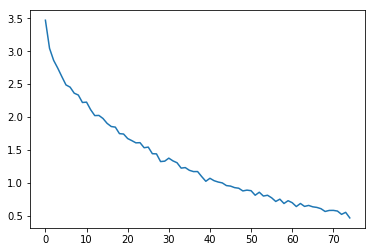

In [16]:
hidden_size = 256
encoder = EncoderRNN(input_lang.n_words,hidden_size)
decoder = DecoderRNN(hidden_size,output_lang.n_words)

trainIters(encoder,decoder,n_iter=75000)

In [17]:
def evaluatePair(encoder,decoder,sentence,max_length = 10):
    input_variable = variableFromSentence(input_lang,sentence)
    input_length = input_variable.size()[0]
    
    encoder_hidden = encoder.initHidden()
    
    for ei in range(input_length):
        encoder_output,encoder_hidden = encoder(input_variable[ei],encoder_hidden)
    
    decoder_input = Variable(torch.LongTensor([[SOS_token]]))
    decoder_hidden = encoder_hidden
    
    decoder_words = []
    
    for di in range(max_length):
        decoder_output,decoder_hidden = decoder(decoder_input,decoder_hidden)
        topv, topi = decoder_output.data.topk(1)
        next_index = topi[0][0]
        
        if next_index==EOS_token:
            decoder_words.append('<EOS>')
            break
        else:
            decoder_words.append(output_lang.index2word[next_index])
            
        decoder_input = Variable(torch.LongTensor([[next_index]]))
    
    return decoder_words

def evaluate(encoder,decoder,n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print ("Input: ",pair[0])
        print ("Ground Truth: ",pair[1])
        output_words = evaluatePair(encoder,decoder,pair[0])
        output_sentence = ' '.join(output_words)
        print ("Translation: ",output_sentence)
        print ("\n\n")

In [18]:
evaluate(encoder,decoder,5)

Input:  je suis trop vieux pour aller en allemagne .
Ground Truth:  i m too old to go to germany .
Translation:  i m too old to go to go . <EOS>



Input:  vous ne convenez pas .
Ground Truth:  you re not fit .
Translation:  you re not paying . <EOS>



Input:  tu es seule n est ce pas ?
Ground Truth:  you re alone aren t you ?
Translation:  you re impressed aren t you ? <EOS>



Input:  je ne vous en empeche pas .
Ground Truth:  i m not stopping you .
Translation:  i m not listening you . <EOS>



Input:  il est une autorite reconnue sur le sujet .
Ground Truth:  he is a recognized authority on the subject .
Translation:  he is a member authority on the subject . <EOS>



